# Treeple Tutorial for calculating S@98

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sklearn.metrics import RocCurveDisplay, roc_curve

## S@98

Sensitivity at 98% specificity (*S@98*) measures, namely, the true positive rate (*TPR*) when the false positive rate (*FPR*) is at 98%. 

With a binary class simulation as an example, this tutorial will show how to use `treeple` to calculate the statistic.

In [2]:
def Calculate_SA98(y_true, y_pred_proba, max_fpr=0.02) -> float:
    # check the shape of true labels
    if y_true.squeeze().ndim != 1:
        raise ValueError(f"y_true must be 1d, not {y_true.shape}")
        
    # find the positive class and calculate fpr and tpr
    if 0 in y_true or -1 in y_true:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=1, drop_intermediate=False
        )
    else:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=2, drop_intermediate=False
        )
    s98 = max([tpr for (fpr, tpr) in zip(fpr, tpr) if fpr <= max_fpr])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label="ROC Curve")
    return s98

## Create a simulation with two gaussians

In [3]:
# create a binary class simulation with two gaussians
# 500 samples for each class, class zero is standard
# gaussian, and class one has a mean at one
X, y = make_trunk_classification(
    n_samples=1000,
    n_dim=1,
    mu_0=0,
    mu_1=1,
    n_informative=1,
    seed=1,
)

## Fit the model

In [4]:
# initialize the forest with 100 trees
est = HonestForestClassifier(
    n_estimators=100,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    random_state=1,
)

# fit the model and obtain the tree posteriors
_, observe_proba = build_hyppo_oob_forest(est, X, y)

# generate forest posteriors for the two classes
observe_proba = np.nanmean(observe_proba, axis=0)

## Calculate the statistic

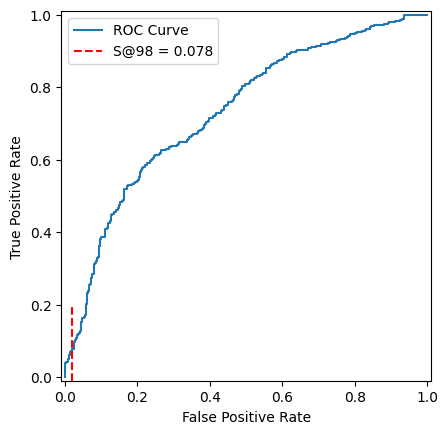

In [5]:
sa98 = Calculate_SA98(y, observe_proba)
plt.axvline(x = 0.02, color = 'r', ymin = 0, ymax = 0.2, label="S@98 = "+str(sa98), linestyle ="--")
plt.legend()